In [1]:
from itertools import combinations

import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import wilcoxon, kendalltau

from evaluation.tools import load_data, get_equal_pairs, get_valid
from evaluation.SETTINGS import investigated_metrics

In [2]:
data = load_data()

Annotated data loaded


Some metrics cannot be aggregated via mean (e.g., BLEU). Want to cut these out of the analysis:

In [97]:
mean_to_corpus_diffs, mean_to_corpus_pct_diffs = [], []

for campaign in data:
    for system in data[campaign]:
        human_data = data[campaign][system]['hum_annotations']
        auto_data = data[campaign][system]['hum_only_automatic_metrics']
        if isinstance(auto_data, dict) and auto_data == {}:
            auto_data = data[campaign][system]['automatic_metrics']
        if isinstance(auto_data, pd.DataFrame):
            auto_data = auto_data.set_index('Unnamed: 0').to_dict()[0]
        human_data_means = human_data[[col for col in human_data if col.startswith("metric")]].mean()
        mean_diffs, mean_pct_diffs = {}, {}
        for metric, corpus_val in auto_data.items():
            try:
                sentence_mean = human_data_means[f"metric_{metric}"]
            except KeyError:
                continue
            
            mean_diffs[metric] = (sentence_mean - corpus_val)
            mean_pct_diffs[metric] = (sentence_mean - corpus_val) / corpus_val
        mean_to_corpus_diffs.append(mean_diffs)
        mean_to_corpus_pct_diffs.append(mean_pct_diffs)

mean_to_corpus_diffs = pd.DataFrame(mean_to_corpus_diffs)
mean_to_corpus_pct_diffs = pd.DataFrame(mean_to_corpus_pct_diffs)


C:\Users\ahoyl\AppData\Local\Temp/ipykernel_1956/489513427.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  mean_pct_diffs[metric] = (sentence_mean - corpus_val) / corpus_val


In [ ]:
max_pct_diffs = mean_to_corpus_pct_diffs.abs().max()
investigated_metrics = list(max_pct_diffs.loc[np.isclose(max_pct_diffs, 0, atol=1e-5)].index)
investigated_metrics

(mean_to_corpus_pct_diffs * 100).

Make a large dataframe

In [4]:
data_df = []
for campaign in data:
    for system in data[campaign]:
        human_data = data[campaign][system]['hum_annotations']
        human_data["campaign"] = campaign
        human_data["system"] = system
        data_df.append(human_data)
data_df = pd.concat(data_df, ignore_index=True)
data_df = data_df.drop("Unnamed: 0", axis=1)

In [5]:
results = []
for campaign in tqdm(data_df.campaign.unique()):
    campaign_df = data_df.loc[data_df.campaign == campaign]
    systems = campaign_df.system.unique()
    for system_a, system_b in combinations(systems, 2):
        system_a_df = campaign_df.loc[campaign_df.system == system_a]
        system_b_df = campaign_df.loc[campaign_df.system == system_b]
        
        # below pulled from the original analysis.py
        skip_pair = False
        for metric in investigated_metrics:
            if metric not in data[campaign][system_a]['automatic_metrics'] or metric not in data[campaign][system_b]['automatic_metrics']:
                skip_pair = True
        if skip_pair:
            continue

        # get human score diff
        system_a_df, system_b_df = get_valid(system_a_df), get_valid(system_b_df)
        if len(system_a_df) != len(system_b_df) or sum(abs(system_a_df['SegmentID'] - system_b_df['SegmentID'])) != 0:
            system_a_df, system_b_df = get_equal_pairs(system_a_df, system_b_df)
            
            # double check that segment ids are equal
            if sum(abs(system_a_df['SegmentID']-system_b_df['SegmentID'])) != 0:
                raise ValueError("SegmentIDs are not equal")

        human_score_diff = system_a_df["Score"].mean() - system_b_df["Score"].mean()

        # get automated score diff
        auto_score_diffs, accuracies = {}, {}
        for metric in investigated_metrics:
            auto_score_diff = system_a_df[f"metric_{metric}"].mean() - system_b_df[f"metric_{metric}"].mean()
            auto_score_diffs[f"{metric}_diff"] = auto_score_diff
            accuracies[f"{metric}_acc"] = np.sign(auto_score_diff) == np.sign(human_score_diff)

        differences = (system_a_df["Score"] - system_b_df["Score"]).to_list()
        if np.sum(differences) == 0:
            # print("System appears to have been repeated, dropping")
            continue 

        if len(differences) < 100:
            raise ValueError("There is too few lines, something is wrong!")

        t_stat, p_value_twosided = wilcoxon(differences, alternative='two-sided')

        result = {
            "campaign": campaign,
            "system_a": system_a,
            "system_b": system_b,
            "human_score_diff": human_score_diff,
            "human_p_value": p_value_twosided,
            **auto_score_diffs,
            **accuracies,
        }
        results.append(result)

results = pd.DataFrame(results)


  5%|▍         | 82/1728 [00:13<04:00,  6.84it/s]C:\Users\ahoyl\.conda\envs\sim-compare\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
100%|██████████| 1728/1728 [04:28<00:00,  6.44it/s]


In [10]:
campaign_names = results.campaign.unique()

# if sampling by campaign
sampled_campaigns = np.random.choice(campaign_names, 10)
sampled_subset = results.loc[results.campaign.isin(sampled_campaigns)]

sampled_subset

,campaign,system_a,system_b,human_score_diff,human_p_value,COMET_diff,COMET_src_diff,BERT_SCORE_diff,Prism_ref_diff,Prism_src_diff,...,CharacTER_neg_diff,ESIM__diff,COMET_acc,COMET_src_acc,BERT_SCORE_acc,Prism_ref_acc,Prism_src_acc,BLEURT_default_acc,CharacTER_neg_acc,ESIM__acc
122,06747b724a6c05d863c3807f22574f32,13f1d5f1838280fa11793328b00eace6.xlsx,1a61b216ac6855c4eee7917302083625.xlsx,0.623158,7.674300e-01,0.102786,-0.011294,0.010458,0.206265,-0.059953,...,0.102496,0.119726,True,False,True,True,False,True,True,True
123,06747b724a6c05d863c3807f22574f32,13f1d5f1838280fa11793328b00eace6.xlsx,97f95ca3d485a1451734f665a2af3084.xlsx,-5.863158,3.217861e-07,0.006419,-0.039311,0.005170,0.070960,-0.114512,...,0.072209,0.055519,False,True,False,False,True,False,False,False
124,06747b724a6c05d863c3807f22574f32,13f1d5f1838280fa11793328b00eace6.xlsx,b91985dbc06ea031b20b09a24d6c3d43.xlsx,10.507368,3.434904e-12,0.280974,0.067370,0.022511,0.497128,0.305115,...,0.170366,0.219436,True,True,True,True,True,True,True,True
125,06747b724a6c05d863c3807f22574f32,1a61b216ac6855c4eee7917302083625.xlsx,97f95ca3d485a1451734f665a2af3084.xlsx,-6.486316,3.739972e-06,-0.096367,-0.028017,-0.005288,-0.135305,-0.054559,...,-0.030286,-0.064206,True,True,True,True,True,True,True,True
126,06747b724a6c05d863c3807f22574f32,1a61b216ac6855c4eee7917302083625.xlsx,b91985dbc06ea031b20b09a24d6c3d43.xlsx,9.884211,4.668022e-14,0.178188,0.078664,0.012053,0.290863,0.365068,...,0.067870,0.099711,True,True,True,True,True,True,True,True
127,06747b724a6c05d863c3807f22574f32,97f95ca3d485a1451734f665a2af3084.xlsx,b91985dbc06ea031b20b09a24d6c3d43.xlsx,16.370526,1.717428e-24,0.274555,0.106681,0.017341,0.426168,0.419626,...,0.098156,0.163917,True,True,True,True,True,True,True,True
222,111601882e0dd6e9b56b7d2e4aeb59c9,6f7b1a3e7fcfd92549a4b1ef1755e9fa.xlsx,e53e70014a24a6bca8524a9084e2fa10.xlsx,-0.680958,1.687311e-01,-0.012046,-0.002336,-0.001295,-0.017724,-0.006702,...,-0.002458,-0.010090,True,True,True,True,True,True,True,True
264,13d811d4100f049c154d0c460579b7d7,4632a11b469b6e9f7b336332ffe3251b.xlsx,7207952ee71fad930b1c1985bc63c1b8.xlsx,3.027397,1.356069e-03,0.043041,-0.012134,0.007469,0.219864,-0.180629,...,0.095680,0.078469,True,False,True,True,False,True,True,True
330,18e6afddc82f3277a2b64ea7ab14c198,d83eb5ff1b52708a5e2d849ecd3d286c.xlsx,ea006d1cadc6d89d0cfc6c663b0ac23e.xlsx,1.741071,9.830988e-02,0.070575,0.029887,0.004059,0.050134,0.056424,...,0.014483,0.021523,True,True,True,True,True,True,True,True
348,1b710fd6e4e05d8b6a9f7b5d4de49721,c595383cc279e10085f0880b05b1789c.xlsx,d54bd71734d116b18158274245f68037.xlsx,-3.486047,4.298543e-07,-0.098170,-0.038645,-0.007014,-0.155136,-0.131876,...,-0.029193,-0.060798,True,True,True,True,True,True,True,True


In [127]:
# TODO: sample irrespective of campaign

campaign_subsamples = pd.DataFrame()
alphas = [1, 0.05]
sims = 500
metric_acc_cols = [c for c in results if c.endswith("_acc")]

campaign_names = results.campaign.unique()

n_systems = list(range(2, 50, 1))# + list(range(50, len(results) - sims, 5))
for n in tqdm(n_systems): #tqdm(range(2, len(results) - sims, 5)): #tqdm(range(2, len(campaign_names) - sims, 2)):
    for i in range(sims):

        # if sampling by campaign
        # sampled_campaigns = np.random.choice(campaign_names, n)
        # sampled_subset = results.loc[results.campaign.isin(sampled_campaigns)]

        # if sampling irrespective of campaign
        sampled_subset = results.sample(n, replace=False)

        # sample n campaigns
        for alpha in alphas:
            acc = sampled_subset.loc[sampled_subset.human_p_value <= alpha, metric_acc_cols].mean()
            acc["n"] = n
            acc["sim"] = i
            acc["alpha"] = alpha
            acc = acc.to_frame().T
            campaign_subsamples = pd.concat([campaign_subsamples, acc])

  0%|          | 0/48 [00:00<?, ?it/s]

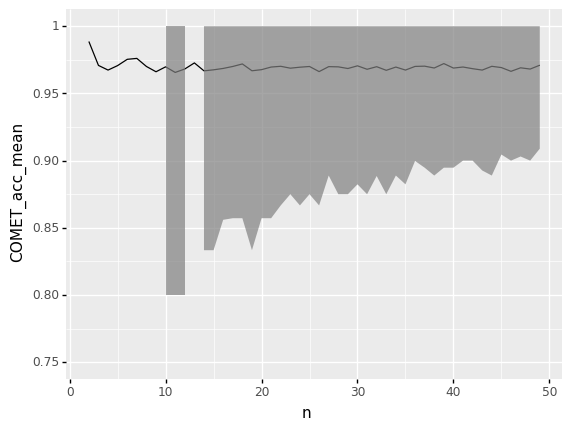

<ggplot: (78568605227)>

In [128]:
from plotnine import ggplot, geom_line, geom_point, aes, geom_ribbon

campaign_subsamples_summary = (
    campaign_subsamples.loc[campaign_subsamples.n < 50]
                       .groupby(['n', 'alpha'])
                       .agg([
                           ('mean', np.mean),
                           ('std', np.std),
                           ('ci_lb', lambda x: np.quantile(x, 0.05)),
                           ('ci_ub', lambda x: np.quantile(x, 0.95)),
                           #('diff', lambda x: np.abs(true_mean - np.quantile(x, [0.05, 0.95])).max())
                       ])
                       .reset_index()
)
campaign_subsamples_summary.columns = ["_".join(c) if c[1] else c[0] for c in campaign_subsamples_summary.columns.to_flat_index()]

(
    ggplot(campaign_subsamples_summary.loc[campaign_subsamples_summary.alpha == 0.05], aes(x='n', y='COMET_acc_mean')) +
    geom_line() +
    geom_ribbon(aes(ymin = 'COMET_acc_ci_lb', ymax = 'COMET_acc_ci_ub'), fill = "grey", alpha=0.7)
)

In [130]:
from tqdm.notebook import tqdm
from scipy.stats import norm, ttest_ind

actual_data_samples = []
bootstrap_subsamples = []

data_df["campaign_sys"] = data_df.campaign + "_" + data_df.system
total_runs = data_df["campaign_sys"].nunique()
campaign_systems = data_df["campaign_sys"].unique()
avg_examples = int(data_df.groupby(['campaign_sys']).size().mean())
sims = 250
bootstraps = 200

def calculate_differences(system_a_df, system_b_df, investigated_metrics):
    human_score_diff = system_a_df["Score"].mean() - system_b_df["Score"].mean()
    if human_score_diff == 0:
        return None
    
    # get automated score diff
    auto_score_diffs, accuracies = {}, {}
    for metric in investigated_metrics:
        auto_score_diff = system_a_df[f"metric_{metric}"].mean() - system_b_df[f"metric_{metric}"].mean()
        auto_score_diffs[f"{metric}_diff"] = auto_score_diff
        accuracies[f"{metric}_acc"] = np.sign(auto_score_diff) == np.sign(human_score_diff)

    # t_stat, p_value_twosided = wilcoxon(differences, alternative='two-sided')
    _, p_value_twosided = ttest_ind(system_a_df["Score"].values, system_b_df["Score"].values, alternative='two-sided')

    return {
        "bootstrap": j,
        "human_score_diff": human_score_diff,
        "human_p_value": p_value_twosided,
        **auto_score_diffs,
        **accuracies,
    }

def estimate_metric_accuracy(system_evals, metric_cols, investigated_alphas=[1, 0.05]):
    for alpha in investigated_alphas:
        acc = system_evals.loc[system_evals.human_p_value <= alpha, metric_cols].mean()
        acc["alpha"] = alpha
        acc = acc.to_frame().T
        return acc

n_systems = list(range(2, 50, 1)) #+ list(range(2, total_runs - sims, 50))
with tqdm(total=len(n_systems) * sims * bootstraps) as pbar:
    for n in n_systems:
        # sample from the total "population" of possible systems
        for i in range(sims):
            sampled_systems = np.random.choice(campaign_systems, n)
            sampled = data_df.loc[data_df.campaign_sys.isin(sampled_systems)]
            sampled = sampled.sort_values("Score")

            actual_data = []
            for system_a, system_b in combinations(sampled_systems, 2):
                system_a_df = sampled.loc[sampled.campaign_sys == system_a]
                system_b_df = sampled.loc[sampled.campaign_sys == system_b]
                result = calculate_differences(system_a_df, system_b_df, investigated_metrics)
                actual_data.append(result)

            actual_data_acc = estimate_metric_accuracy(pd.DataFrame(actual_data), metric_acc_cols)
            actual_data_acc["n"] = n
            actual_data_acc["sim"] = i
            actual_data_samples.append(actual_data_acc)

            bootstrap_data = []
            for j in range(bootstraps):
                # # TODO: fair amount of thinking around how samples should happen
                mean_a, mean_b = np.random.uniform(0, 1, 2)

                prob_a = norm.pdf(np.linspace(0, 1, len(sampled)), mean_a, 0.05)
                #prob_a = prob_a / prob_a.sum()
                prob_b = norm.pdf(np.linspace(0, 1, len(sampled)), mean_b, 0.05)
                #prob_b = prob_b / prob_b.sum()

                system_a_df = sampled.sample(n=avg_examples, weights=prob_a)
                system_b_df = sampled.sample(n=avg_examples, weights=prob_b) # TODO: look at resulting dists.
    
                # system_a_df = sampled.sample(n=avg_examples)
                # system_b_df = sampled.sample(n=avg_examples)
                result = calculate_differences(system_a_df, system_b_df, investigated_metrics)
                if result is not None:
                    bootstrap_data.append(result)
                pbar.update()

            # average over bootstrapped data
            bootstrap_data = pd.DataFrame(bootstrap_data)
            bootstrap_acc = estimate_metric_accuracy(bootstrap_data, metric_acc_cols)
            bootstrap_acc["n"] = n
            bootstrap_acc["sim"] = i
            bootstrap_subsamples.append(bootstrap_acc)

    actual_data_samples = pd.concate(actual_data_samples, ignore_index=True)
    bootstrap_subsamples = pd.concat(bootstrap_subsamples, ignore_index=True)


  0%|          | 0/2400000 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (472,) (504,) 

In [113]:
bootstrap_subsamples = pd.concat(bootstrap_subsamples, ignore_index=True)

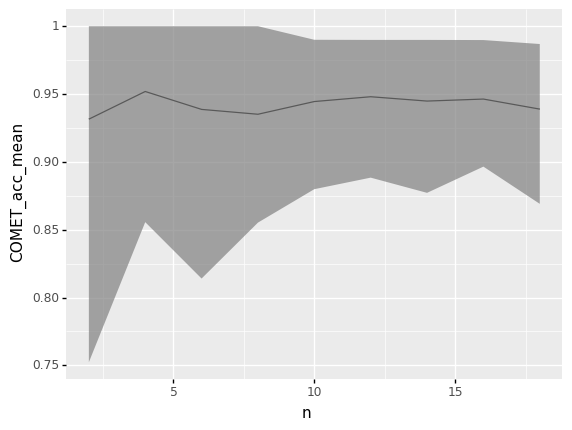

<ggplot: (78389190355)>

In [114]:
from plotnine import ggplot, geom_line, geom_point, aes, geom_ribbon

bootstrap_subsamples_summary = (
    bootstrap_subsamples#.loc[campaign_subsamples.n < 50]
                       .groupby(['n', 'alpha'])
                       .agg([
                           ('mean', np.mean),
                           ('std', np.std),
                           ('ci_lb', lambda x: np.quantile(x, 0.05)),
                           ('ci_ub', lambda x: np.quantile(x, 0.95)),
                           #('diff', lambda x: np.abs(true_mean - np.quantile(x, [0.05, 0.95])).max())
                       ])
                       .reset_index()
)
bootstrap_subsamples_summary.columns = ["_".join(c) if c[1] else c[0] for c in bootstrap_subsamples_summary.columns.to_flat_index()]

(
    ggplot(bootstrap_subsamples_summary.loc[bootstrap_subsamples_summary.alpha == 0.05], aes(x='n', y='COMET_acc_mean')) +
    geom_line() +
    geom_ribbon(aes(ymin = 'COMET_acc_ci_lb', ymax = 'COMET_acc_ci_ub'), fill = "grey", alpha=0.7)
)

In [118]:
for alpha in [1, 0.05, 0.01, 0.001]:
    acc = results.loc[results.human_p_value <= alpha, "accuracy"]
    print(f"N: {len(acc)}, {alpha:0.03f}, {acc.mean():0.03f}")

N: 3344, 1.000, 0.806
N: 1717, 0.050, 0.945
N: 1420, 0.010, 0.970
N: 1176, 0.001, 0.983


,campaign,system_a,system_b,human_score_diff,human_p_value,auto_score_diff,accuracy
0,0001119f8b0cf0a4c8ac7bf2d9a21381,9da92d668693b7bd994d9748f6e7958c.xlsx,e71a78d7eb257e0bc76f4b2694369e94.xlsx,0.569106,3.825327e-01,-0.003052,False
1,001f03cc6a7b32dfe8de6d39f122bc83,6b37a2dcaf725b2677386264e6300cde.xlsx,99d6d239a084c1fa10b8f28482e30e17.xlsx,0.014354,8.780092e-01,0.000647,True
2,001f03cc6a7b32dfe8de6d39f122bc83,6b37a2dcaf725b2677386264e6300cde.xlsx,ec290d69da76a1bcc4f92ce63a88a3b7.xlsx,-0.992754,1.024241e-01,-0.045885,True
3,001f03cc6a7b32dfe8de6d39f122bc83,6b37a2dcaf725b2677386264e6300cde.xlsx,ffbd343288c0df9d749b069b3b92cc3f.xlsx,-1.450180,5.526978e-02,-0.050674,True
4,001f03cc6a7b32dfe8de6d39f122bc83,99d6d239a084c1fa10b8f28482e30e17.xlsx,ec290d69da76a1bcc4f92ce63a88a3b7.xlsx,-1.109375,7.132558e-02,-0.046532,True
...,...,...,...,...,...,...,...
3339,ff0d7bc929686daa96b3fd3608c87fc5,1cae17051bba96a9dd5cad1d09fd3172.xlsx,2ed9ed05f6b71956458046660a09c5ff.xlsx,-1.294505,6.678981e-01,-0.029616,True
3340,ff0d7bc929686daa96b3fd3608c87fc5,1cae17051bba96a9dd5cad1d09fd3172.xlsx,b91985dbc06ea031b20b09a24d6c3d43.xlsx,14.727473,1.494038e-28,0.363178,True
3341,ff0d7bc929686daa96b3fd3608c87fc5,2ed9ed05f6b71956458046660a09c5ff.xlsx,b91985dbc06ea031b20b09a24d6c3d43.xlsx,16.021978,6.588806e-34,0.392794,True
3342,ffcd70ddb7ba8a84b2b8530beeb35e53,eab644d88f02bee2fc3bc2e5f5d67589.xlsx,ece5b0b0a8b755885d5f8b774577fb28.xlsx,1.543779,7.950365e-04,0.324107,True


In [36]:
import pickle

with open("./statistical_data.pickle", "rb") as infile:
    statistical_data = pickle.load(infile)

In [67]:
results_original = pd.DataFrame(statistical_data)

results_original['accuracy'] = np.sign(results_original['human1']) == np.sign(results_original[METRIC])

In [119]:
results = (
    results.replace("\\.xlsx", "", regex=True)
           .rename({
               "system_a": "SystemAid",
               "system_b": "SystemBid",
               "human_p_value": "human_p_value_new",
               "accuracy": "accuracy_new"
            },
            axis='columns',
            )    
)

In [120]:
results_merged = results_original[['campaign', 'SystemAid', 'SystemBid', 'accuracy', 'human_pvalue', METRIC]].merge(results)

In [121]:
results_merged['diff_of_diff'] = np.abs(results_merged[METRIC] - results_merged['auto_score_diff'])

In [124]:
results_merged.sort_values('diff_of_diff').max()

campaign             ffdcaad19e1e58a70563371fad02c141
SystemAid            f7e17531e5935e6d6be48f6f3fba5b00
SystemBid            ffd2d560c712ac3cb62dbca7675790f5
accuracy                                         True
human_pvalue                                      1.0
Prism_ref                                    1.099608
human_score_diff                            28.482105
human_p_value_new                                 1.0
auto_score_diff                              1.099608
accuracy_new                                     True
diff_of_diff                                      0.0
dtype: object

In [115]:

campaign_df = data_df.loc[data_df.campaign == 'd38a89488e5ed4e0706a849a640a99a0']
system_a_df = campaign_df.loc[campaign_df.system == '13f1d5f1838280fa11793328b00eace6.xlsx']
system_b_df = campaign_df.loc[campaign_df.system == 'b91985dbc06ea031b20b09a24d6c3d43.xlsx']

system_a_df.metric_Prism_ref.mean() - system_b_df.metric_Prism_ref.mean()

-0.004476666706314303

# Next steps
* Probably do all analyses with a single language pair, to start.
* Randomly subsample data at multiple sizes (1%, 5%, etc.). For each size, show variance across each "seed" pool (e.g., the initial set of campaigns)
    * Subsample by campaign, but otherwise maintain same strategy (basically what happened above with the reduced release). Equivalent to running fewer system pairs.
    * Subsample by campaign, but pool data and partition to create pseudo-systems.
    * Subsample by language pair: pooled dataset is partitioned to create pseudo-systems.
    * Subsample completely at random, across languages.
* Strategically subsample: pick campaigns/systems such that spread is maximized/minimized across, say, geom mean of the different metric types, or human scores.
    * Strategically partition (?) by weighing (?) examples s.t. differences between pseudo-systems show large variation (not all "close" to one another)
* Redo the above for the 'precision' (since this table is basically 'recall'): when a metric tells you "difference", how often is there a sig. human difference?
* 